<a href="https://colab.research.google.com/github/sagiodev/stablediffusion_webui/blob/master/DreamBooth_Stable_Diffusion_SDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-click execution of Dreambooth Stable Diffusion
- Dec 21, 2023 - Updated diffusers to the current version.
- Dec 14, 2023 - Fixed bitsandbytes import error.
- Oct 21,2023 - Fixed xformers version.
- Aug 16, 2023 - Custom model output name.
- July 19,2023 - Updated accelerate version, again.


Tutorials and prompts at [stable-diffusion-art.com](https://stable-diffusion-art.com)

The latest copy can be found [here](https://colab.research.google.com/github/sagiodev/stablediffusion_webui/blob/master/DreamBooth_Stable_Diffusion_SDA.ipynb).


See the [Dreambooth tutorial](https://stable-diffusion-art.com/dreambooth/) for a step-by-step guide. Leave comment under article if you have any questions.



In [1]:
import time

#@title DreamBooth
HUGGINGFACE_TOKEN = ""

#@markdown Name/Path of the initial model. (Find model name [here](https://huggingface.co/models))
MODEL_NAME = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}
BRANCH = "fp16" #@param {type:"string"}

#@markdown Enter instance prompt and class prompt.\
#@markdown Example 1: photo of zwx person, photo of a person\
#@markdown Example 2: photo of zwx toy, photo of a toy
instance_prompt = "photo of zwx toy" #@param {type:"string"}
class_prompt =  "photo of a toy" #@param {type:"string"}
training_steps = 400 #@param {type:"integer"}
learning_rate = 5e-6 #@param {type:"number"}
output_file = "AI_PICS/models/my_dreambooth_model.safetensors" #@param {type:"string"}
#@markdown  Convert to fp16? (takes half the space (2GB)).
fp16 = True #@param {type: "boolean"}

#@markdown Clear log after run?
CLEAR_LOG = False #@param {type:"boolean"}

# Mount google drive for saving the model
from google.colab import drive
drive.mount('/content/drive')


OUTPUT_DIR = "/content/output"
INSTANCE_DIR = "/content/data/instance"
CLASS_DIR = "/content/data/class"
!mkdir -p $INSTANCE_DIR
!mkdir -p $CLASS_DIR
!mkdir -p $OUTPUT_DIR

# Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

# Upload training images.
import os
from google.colab import files
import shutil
uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(INSTANCE_DIR, filename)
    shutil.move(filename, dst_path)

time_start = time.time()
def clear():
    from IPython.display import clear_output; return clear_output()

# huggingface token
!mkdir -p ~/.huggingface
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token


# install diffusers
!git clone https://github.com/sagiodev/diffusers.git #https://github.com/huggingface/diffusers.git
%cd diffusers
!git checkout 08b453e3828f80027d881bb460716af95e192bcd -- ./scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install .


# install dreambooth
%cd /content/diffusers/examples/dreambooth
%pip install -r requirements.txt
%pip install bitsandbytes #xformers torch==2.1.0+cu121 # gradio natsort safetensors xformers torch==2.1.0+cu121 accelerate
!accelerate config default


# test bitsandbytes
import bitsandbytes
import torch
print(torch.__version__)

# Dreambooth training - Edit this section to customize parameters
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --variant=$BRANCH \
  --instance_prompt="$instance_prompt" \
  --class_prompt="$class_prompt" \
  --class_data_dir=$CLASS_DIR \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=$learning_rate \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=$training_steps

#  --enable_xformers_memory_efficient_attention \

########################################

ckpt_path = '/content/drive/MyDrive/' + output_file
# save model file. Save to a new name if already exist.
dirname= os.path.dirname(ckpt_path)
filename = os.path.basename(ckpt_path)
fileanmeWithoutExt = os.path.splitext(filename)[0]
ExtName = os.path.splitext(filename)[1]
filenamePattern = fileanmeWithoutExt + '%d' + ExtName
i = 1
while os.path.isfile(ckpt_path):
  filename = filenamePattern%i
  ckpt_path = dirname + '/' + filename
  i += 1

half_arg = "--half" if fp16 else ""
!python /content/diffusers/scripts/convert_diffusers_to_original_stable_diffusion.py \
    --use_safetensors \
    --model_path $OUTPUT_DIR \
    --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")
minutes = (time.time()-time_start)/60
print("Dreambooth completed successfully. It took %1.1f minutes."%minutes)

Mounted at /content/drive
Tesla V100-SXM2-16GB, 16384 MiB, 16151 MiB


Saving 0E5AFC83-B759-4FE9-8E16-A60774E1DEDF_1_105_c.jpeg to 0E5AFC83-B759-4FE9-8E16-A60774E1DEDF_1_105_c.jpeg
Saving 3E0FD8C0-2A5B-4F60-AB75-46E7E4A54A39_1_105_c.jpeg to 3E0FD8C0-2A5B-4F60-AB75-46E7E4A54A39_1_105_c.jpeg
Saving 7BFAC61C-85ED-4E82-8B8D-F518F9C54BA8_1_105_c.jpeg to 7BFAC61C-85ED-4E82-8B8D-F518F9C54BA8_1_105_c.jpeg
Saving 8A911A8C-729E-44CD-A8CD-6B8A63D4FB7E_1_105_c.jpeg to 8A911A8C-729E-44CD-A8CD-6B8A63D4FB7E_1_105_c.jpeg
Saving 21A20E5D-C929-4F71-929D-2E0BE455DABA_1_105_c.jpeg to 21A20E5D-C929-4F71-929D-2E0BE455DABA_1_105_c.jpeg
Saving 667FCDEA-E101-4DFD-9151-3D555F3073D6_1_105_c.jpeg to 667FCDEA-E101-4DFD-9151-3D555F3073D6_1_105_c.jpeg
Saving 6410DB7A-4305-4B8C-8643-F2B60DC21610_1_105_c.jpeg to 6410DB7A-4305-4B8C-8643-F2B60DC21610_1_105_c.jpeg
Saving B9C73770-329E-4D12-8FBF-648750F41D01_1_105_c.jpeg to B9C73770-329E-4D12-8FBF-648750F41D01_1_105_c.jpeg
Saving F68F3AD8-B260-4392-89E7-F9E41523C29F_1_105_c.jpeg to F68F3AD8-B260-4392-89E7-F9E41523C29F_1_105_c.jpeg
Saving FA8

/content


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:182: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.25.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request f

  0%|          | 0/25 [00:00<?, ?it/s]

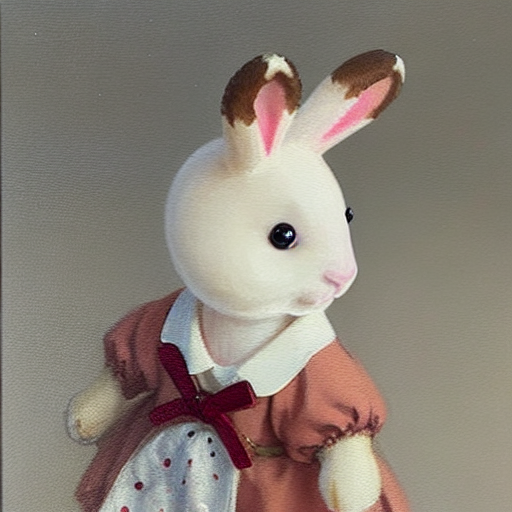

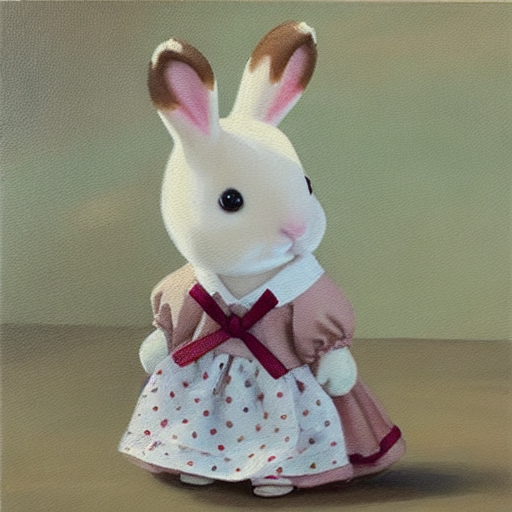

In [2]:
#@title Test image generation from model

prompt = "Oil painting of zwx in style of van Gogh" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 2 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 25 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}
seed = 100 #@param {type:"number"}

%cd /content/
from diffusers import StableDiffusionPipeline,DDIMScheduler
from IPython.display import display

model_path = 'output'
if 'pipe' not in locals():
  scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
  pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  g_cuda = None



g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)